In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = "D:\\Bootcamp\\MIMIC IV\\"
admissions = pd.read_csv(path + "core\\admissions.csv.gz", compression='gzip')
patients = pd.read_csv(path + "core\\patients.csv.gz", compression='gzip')
# transfers = pd.read_csv(path + "core\\transfers.csv.gz", compression='gzip')

diagnoses = pd.read_csv(path + "hosp\\diagnoses_icd.csv.gz", compression='gzip')
d_diagnoses = pd.read_csv(path + "hosp\\d_icd_diagnoses.csv.gz", compression='gzip')
drg_codes = pd.read_csv(path + "hosp\\drgcodes.csv.gz", compression='gzip')

d_lab_events = pd.read_csv(path + "hosp\\d_labitems.csv.gz", compression='gzip')

In [4]:
# basic cleanup
admissions.admittime = pd.to_datetime(admissions.admittime)
admissions.dischtime = pd.to_datetime(admissions.dischtime)
admissions.ethnicity = admissions.ethnicity.str.lower()

diagnoses.icd_code = diagnoses.icd_code.str.strip()

d_diagnoses.icd_code = d_diagnoses.icd_code.str.strip()
d_diagnoses.long_title = d_diagnoses.long_title.str.lower()

drg_codes = drg_codes.drop_duplicates().groupby('hadm_id').first().reset_index()
drg_codes.description = drg_codes.description.str.lower()

# Generate Sample List

In [5]:
# basic feature engineering for identifying positive cases
pos_codes = d_diagnoses[(d_diagnoses['long_title'].str.contains('heart failure'))]
pos_codes = pos_codes[~pos_codes.long_title.str.contains('without')]
pos_diagnoses = diagnoses[diagnoses['icd_code'].isin(pos_codes.icd_code)]
admissions['pos_subj'] = np.where(admissions.subject_id.isin(pos_diagnoses.subject_id), 1, 0)
admissions['pos_adm'] = np.where(admissions.hadm_id.isin(pos_diagnoses.hadm_id), 1, 0)

# filter out children (ages masked as "0")
admissions = admissions.merge(patients[['subject_id', 'gender', 'anchor_age']], how='left', on=['subject_id'])
admissions = admissions.rename(columns={'anchor_age':'age'})
admissions = admissions[admissions.age > 0]
admissions = admissions.reset_index(drop=True)

In [6]:
# create dataframes for first positive visits and most recent previous visits
first_adm = admissions.iloc[admissions[admissions.pos_subj==1].groupby('subject_id').admittime.idxmin()]
subj_list = first_adm[first_adm.pos_adm==0].subject_id.unique()

# create refernce dataframe
subj_admissions = admissions[admissions.subject_id.isin(subj_list)]
subj_admissions = subj_admissions.sort_values(['subject_id', 'admittime']).reset_index(drop=True)
pos_admissions = subj_admissions[['subject_id', 'hadm_id', 'admittime', 'pos_adm']]
pos_admissions = pos_admissions.loc[pos_admissions[pos_admissions.pos_adm==1].groupby('subject_id').admittime.idxmin()]
pos_admissions = pos_admissions.rename(columns={'pos_adm':'first_pos'}).drop('admittime', axis=1)
subj_admissions = subj_admissions.merge(pos_admissions, how='left')

# slice based on first visit/prior visit
first_idx = subj_admissions[subj_admissions.first_pos==1].index
pos_admissions = subj_admissions.iloc[first_idx].reset_index(drop=True)
pre_admissions = subj_admissions.iloc[first_idx-1].reset_index(drop=True)
pre_admissions['time_delta'] = pos_admissions.admittime - pre_admissions.dischtime
pre_admissions = pre_admissions[pre_admissions.time_delta < pd.to_timedelta('365 days')].reset_index(drop=True)
pos_admissions = pos_admissions[pos_admissions.subject_id.isin(pre_admissions.subject_id)].reset_index(drop=True)

pre_hadm = pre_admissions.hadm_id.values
# pos_hadm = pos_admissions.hadm_id.values

# sample negative patients
neg_admissions = admissions[(admissions.pos_subj==0) & (admissions.admittime < pd.to_datetime('2210'))]
neg_hadm = neg_admissions.hadm_id.unique()
neg_hadm = np.random.choice(neg_hadm, pre_admissions.subject_id.nunique(), replace=False)

#sanity checks
print('Positive cases in previous visit: ', pre_admissions.pos_adm.sum())
# print('Mismatched patient count: ', np.sum(pos_admissions['subject_id'] - pre_admissions['subject_id']))
print('Length of all samples is the same:')
print(len(pre_hadm), len(neg_hadm))
print('Are there any overlapping patients?')
print(pre_admissions.subject_id.unique() in neg_admissions.subject_id.unique())

sample_hadm = np.concatenate((pre_hadm, neg_hadm))

Positive cases in previous visit:  0
Length of all samples is the same:
5304 5304
Are there any overlapping patients?
False


D:\Software\anaconda3\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


# Create Sample Admissions Table

In [7]:
s_cols = ['pos_subj', 'hadm_id', 'subject_id', 'age', 'gender', 'ethnicity',\
          ]
s_admissions = admissions[admissions.hadm_id.isin(sample_hadm)][s_cols]
s_admissions

,pos_subj,hadm_id,subject_id,age,gender,ethnicity
26,0,29402101,12764302,21,F,white
112,1,20793449,14342647,82,M,white
154,0,21630273,14126394,48,F,unknown
169,0,20141347,16622598,28,M,white
222,0,29736293,16698069,21,M,unknown
...,...,...,...,...,...,...
462717,1,25013602,11533366,60,F,black/african american
462729,0,26480289,15403351,70,M,white
462759,1,25094628,11968004,61,M,white
462802,1,29030833,16502265,87,M,black/african american


In [8]:
# feature cleaning
s_admissions.loc[s_admissions.ethnicity=='unable to obtain', 'ethnicity'] = 'unknown'


In [9]:
s_drg = drg_codes[drg_codes.hadm_id.isin(sample_hadm)][['hadm_id', 'description']]
comorbidities =  ['sepsis', 'pneumoia', 'diabetes', 'hypertension',\
              'renal failure', 'kidney failure',\
              'atrial fibrillation', 'atherosclero', 'cardiac arrhythmia']
# come back for "vascular procedures", "coronary bypass", "cardiac congenital"
for comorb in comorbidities:
    s_drg[comorb] =  np.where(s_drg.description.str.contains(comorb), 1, 0)
s_drg.head()

,hadm_id,description,sepsis,pneumoia,diabetes,hypertension,renal failure,kidney failure,atrial fibrillation,atherosclero,cardiac arrhythmia
0,20000019,septicemia or severe sepsis w/o mv 96+ hours w...,1,0,0,0,0,0,0,0,0
46,20001729,"perm cardiac pacemaker implant w/o ami, heart ...",0,0,0,0,0,0,0,0,0
116,20004387,nervous system neoplasms w mcc,0,0,0,0,0,0,0,0,0
198,20006820,major gastrointestinal & peritoneal infections,0,0,0,0,0,0,0,0,0
259,20008546,hypovolemia & related electrolyte disorders,0,0,0,0,0,0,0,0,0


In [10]:
s_icd = diagnoses[diagnoses.hadm_id.isin(sample_hadm)][['hadm_id', 'icd_version', 'icd_code']]
s_icd = s_icd.merge(d_diagnoses, how='left', on=['icd_version', 'icd_code'])
s_icd = s_icd.drop(['icd_code', 'icd_version'], axis=1)
s_icd = s_icd.groupby('hadm_id').agg(description=('long_title', lambda x: ''.join(str(x).rstrip()))).reset_index()
for comorb in comorbidities:
    s_icd[comorb] =  np.where(s_icd.description.str.contains(comorb), 1, 0)
s_icd.head()

,hadm_id,description,sepsis,pneumoia,diabetes,hypertension,renal failure,kidney failure,atrial fibrillation,atherosclero,cardiac arrhythmia
0,20000019,33888 family history of malignant neoplasm ...,1,0,1,1,0,1,0,0,0
1,20001729,103521 scoliosis...,0,0,0,1,0,1,1,1,0
2,20002827,21439 surgical or other procedure not carri...,0,0,0,0,0,0,0,0,0
3,20004387,10375 benign neoplasm of cereb...,0,0,1,0,0,0,0,1,0
4,20006820,42834 intestinal infection due to clostridi...,0,0,0,0,0,0,1,0,0


In [11]:
s_comorb = pd.merge(s_drg, s_icd, how='outer', on='hadm_id').fillna(0)
for co_ in comorbidities:
    s_comorb[co_] = s_comorb[co_+'_x'] + s_comorb[co_+'_y']
    s_comorb[co_] = np.where(s_comorb[co_] > 0, 1, 0)
    s_comorb = s_comorb.drop([co_+'_x', co_+'_y'], axis=1)
s_comorb['renal_failure'] = np.where((s_comorb['renal failure'] + s_comorb['kidney failure']) > 1, 1, 0)
s_comorb['arrhythmia'] = np.where((s_comorb['atrial fibrillation'] + s_comorb['cardiac arrhythmia']) > 1, 1, 0)
s_comorb = s_comorb.drop(['kidney failure', 'renal failure', 'atrial fibrillation', 'cardiac arrhythmia',\
                   'description_x', 'description_y'], axis=1)

In [12]:
s_admissions = s_admissions.merge(s_comorb, how='left', on='hadm_id').fillna(0)
s_admissions.to_pickle('s_admissions.pkl')

In [153]:
s_admissions = pd.read_pickle("s_admissions.pkl")
sample_hadm = s_admissions.hadm_id.values
print(s_admissions.shape)
s_admissions.head()

(10608, 13)


,pos_subj,hadm_id,subject_id,age,gender,ethnicity,sepsis,pneumoia,diabetes,hypertension,atherosclero,renal_failure,arrhythmia
0,0,29402101,12764302,21,F,white,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,20793449,14342647,82,M,white,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,21630273,14126394,48,F,unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,20141347,16622598,28,M,white,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,29736293,16698069,21,M,unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
pd.set_option('max_rows', 40) 
pd.set_option('min_rows', 40)        # display at least 100 rows when max is exceeded

# Create Lab Events Table

In [85]:
# select tests from EDA
sample_items = [50861, 50868, 50882, 50885, 50902, 50912, 50960, \
             50970, 50971, 51006, 51221, 51222, 51237, 51248, \
             51249, 51250, 51265, 51274, 51275, 51277, 51279]

In [16]:
%%time
# load all tests in sample and save to file for reference

chunksize = 3*(10 ** 6)
chunk = 1
cols_ = ['subject_id', 'hadm_id', 'specimen_id', 'itemid', 'value', 'valuenum', 'valueuom', \
         'ref_range_lower', 'ref_range_upper', 'comments', 'flag']
lab_events = []
for lab_chunk in pd.read_csv(path + "hosp\\labevents.csv.gz", compression='gzip', chunksize=chunksize):
    lab_chunk = lab_chunk[lab_chunk.hadm_id.isin(sample_hadm)]
    lab_chunk = lab_chunk[lab_chunk.itemid.isin(sample_items)]
    lab_chunk = lab_chunk[cols_]
    lab_events.append(lab_chunk)
    print(f'Processed chunk: {chunk}')
    chunk += 1

lab_events = pd.concat(lab_events)
lab_events.to_pickle("lab_events.pkl")

Processed chunk: 1
Processed chunk: 2
Processed chunk: 3


<string>:2: DtypeWarning: Columns (7,9,12) have mixed types.Specify dtype option on import or set low_memory=False.


Processed chunk: 4
Processed chunk: 5
Processed chunk: 6
Processed chunk: 7
Processed chunk: 8
Processed chunk: 9


<string>:2: DtypeWarning: Columns (9,12) have mixed types.Specify dtype option on import or set low_memory=False.


Processed chunk: 10


<string>:2: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.


Processed chunk: 11
Processed chunk: 12
Processed chunk: 13
Processed chunk: 14
Processed chunk: 15


<string>:2: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.


Processed chunk: 16
Processed chunk: 17
Processed chunk: 18
Processed chunk: 19
Processed chunk: 20
Processed chunk: 21
Processed chunk: 22
Processed chunk: 23


<string>:2: DtypeWarning: Columns (7,9) have mixed types.Specify dtype option on import or set low_memory=False.


Processed chunk: 24
Processed chunk: 25
Processed chunk: 26
Processed chunk: 27
Processed chunk: 28
Processed chunk: 29
Processed chunk: 30
Processed chunk: 31
Processed chunk: 32
Processed chunk: 33
Processed chunk: 34
Processed chunk: 35
Processed chunk: 36
Processed chunk: 37
Processed chunk: 38
Processed chunk: 39
Processed chunk: 40
Processed chunk: 41
Wall time: 5min 52s


In [146]:
lab_events = pd.read_pickle("lab_events.pkl")
print(lab_events.shape)
lab_events.head()

(870924, 11)


,subject_id,hadm_id,specimen_id,itemid,value,valuenum,valueuom,ref_range_lower,ref_range_upper,comments,flag
13234,12461950,27309147.0,65342799,51221,39.3,39.3,%,36.0,48.0,NaN,NaN
13235,12461950,27309147.0,65342799,51222,13.0,13.0,g/dL,12.0,16.0,NaN,NaN
13236,12461950,27309147.0,65342799,51248,25.7,25.7,pg,27.0,32.0,NaN,abnormal
13237,12461950,27309147.0,65342799,51249,33.1,33.1,%,31.0,35.0,NaN,NaN
13238,12461950,27309147.0,65342799,51250,78,78.0,fL,82.0,98.0,NaN,abnormal


# Lab Events Data Wrangling

### Data Cleaning

In [147]:
%%time

# Can probably make a helper function combining some of the below mapping

# Other invalid value imputation
# For now set them all to normal/most common value
lab_events.loc[(lab_events['value'].isin([np.nan, 'ERROR', 'UNABLE TO REPORT'])), ['value', 'valuenum']] = 1.1
lab_events.loc[(lab_events['itemid'] == 51237) & (lab_events['value'].isin(['>21.8'])), ['value', 'valuenum']] = 22
lab_events.loc[(lab_events['itemid'] == 51237) & (lab_events['value'].isin(['>19.2'])), ['value', 'valuenum']] = 20

lab_events.loc[(lab_events['itemid'] == 51275) &  (lab_events['value'].isin(['>150', '>150.0'])), ['value', 'valuenum']] = 175

# Should we just delete these?
# For 5k patients there are 6 records here
lab_events.loc[(lab_events['itemid'] == 51274) &  (lab_events['value'].isin(['ERROR'])), ['value', 'valuenum']] = 11

# Should we just delete these?
# For 5k patients there are 1 records here
lab_events.loc[(lab_events['itemid'] == 51275) &  (lab_events['value'].isin(['UNABLE TO REPORT'])), ['value', 'valuenum']] = 31

# Clumsy..
lab_events.loc[(lab_events['itemid'] == 51275) &  (lab_events['value'].isin(['34..3'])), ['value', 'valuenum']] = 34.3
lab_events.loc[lab_events.value==':UNABLE TO REPORT', ['value', 'valuenum']] = 'NaN'
lab_events.loc[lab_events.value=='UNABLE', ['value', 'valuenum']] = 'NaN'
lab_events.loc[lab_events.value=='>13.1', ['value', 'valuenum']] = 13

# 51466
lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['value'].isin([np.nan])), ['value']] = lab_events['comments']
lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['value'].isin(['NEG.  ', 'NEG', ' '])), ['value', 'valuenum']] = 0
lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['value'].isin(['TR', 'TR.  ', 'TR*.  '])), ['value', 'valuenum']] = 1
lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['value'].isin(['SM', 'SM .  ', 'SM*.  '])), ['value', 'valuenum']] = 2
lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['value'].isin(['MOD', 'MOD.  ', 'MOD*.  '])), ['value', 'valuenum']] = 3
lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['value'].isin(['LG', 'LG.  ', 'LG*.  ', 'LGE', 'LRG'])), ['value', 'valuenum']] = 4

lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

# 51514
lab_events.loc[(lab_events['itemid'] == 51514) & (lab_events['value'].isin([np.nan])), ['value']] = lab_events['comments']
lab_events.loc[(lab_events['itemid'] == 51514) & (lab_events['value'].isin(['NEG.  ', 'NEG', 'NORMAL.  ', ' '])), ['value', 'valuenum']] = 0
lab_events.loc[(lab_events['itemid'] == 51514) & (lab_events['value'].isin(['>8'])), ['value', 'valuenum']] = 10
lab_events.loc[(lab_events['itemid'] == 51514) & (lab_events['value'].isin(['>12.  ', '>12*.  '])), ['value', 'valuenum']] = 15

# 51464
lab_events.loc[(lab_events['itemid'] == 51464) & (lab_events['value'].isin([np.nan])), ['value']] = lab_events['comments']
lab_events.loc[(lab_events['itemid'] == 51464) & (lab_events['value'].isin(['NEG.  ', 'NEG', ' '])), ['value', 'valuenum']] = 0
lab_events.loc[(lab_events['itemid'] == 51464) & (lab_events['value'].isin(['SM', 'SM .  ', 'SM*.  '])), ['value', 'valuenum']] = 1
lab_events.loc[(lab_events['itemid'] == 51464) & (lab_events['value'].isin(['MOD', 'MOD.  ', 'MOD*.  '])), ['value', 'valuenum']] = 2
lab_events.loc[(lab_events['itemid'] == 51464) & (lab_events['value'].isin(['LG', 'LG.  ', 'LG*.  ', 'LGE'])), ['value', 'valuenum']] = 3

lab_events.loc[(lab_events['itemid'] == 51464) & (lab_events['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events.loc[(lab_events['itemid'] == 51464) & (lab_events['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

# 51487
# Should Pos be marked abnormal?
lab_events.loc[(lab_events['itemid'] == 51487) & (lab_events['value'].isin([np.nan])), ['value']] = lab_events['comments']
lab_events.loc[(lab_events['itemid'] == 51487) & (lab_events['value'].isin(['NEG.  ', 'NEG', ' '])), ['value', 'valuenum']] = 0
lab_events.loc[(lab_events['itemid'] == 51487) & (lab_events['value'].isin(['POS.  ', 'POS', 'POS*.  '])), ['value', 'valuenum']] = 1

lab_events.loc[(lab_events['itemid'] == 51487) & (lab_events['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events.loc[(lab_events['itemid'] == 51487) & (lab_events['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

# 51492
# Should Pos be marked abnormal?
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['value'].isin([np.nan])), ['value']] = lab_events['comments']
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['value'].isin(['___'])), ['value', 'valuenum']] = np.nan
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['value'].isin(['NEG.  ', 'NEG', ' '])), ['value', 'valuenum']] = 0
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['value'].isin(['TR', 'TR.  ', 'TR*.  '])), ['value', 'valuenum']] = 10
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['value'].str.contains('TR.')), ['value', 'valuenum']] = 10
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['value'].isin(['>300'])), ['value', 'valuenum']] = 350
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['value'].isin(['>600.  ', '>600*.  '])), ['value', 'valuenum']] = 700

lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

# 51486
lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['value'].isin([np.nan])), ['value']] = lab_events['comments']
lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['value'].isin(['NEG.  ', 'NEG', ' ', 'N'])), ['value', 'valuenum']] = 0
lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['value'].isin(['TR', 'TR.  ', 'TR*.  '])), ['value', 'valuenum']] = 1
lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['value'].isin(['SM', 'SM .  ', 'SM*.  '])), ['value', 'valuenum']] = 2
lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['value'].isin(['MOD', 'MOD.  ', 'MOD*.  '])), ['value', 'valuenum']] = 3
lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['value'].isin(['LG', 'LG.  ', 'LG*.  ', 'LGE'])), ['value', 'valuenum']] = 4

lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

# 51506
lab_events.loc[(lab_events['itemid'] == 51506) & (lab_events['value'].isin([np.nan])), ['value']] = lab_events['comments']
lab_events.loc[(lab_events['itemid'] == 51506) & (lab_events['value'].isin(['Clear.  ', 'CLEAR.  ', 'Clear', ' ', 'CLEAR'])), ['value', 'valuenum']] = 0
lab_events.loc[(lab_events['itemid'] == 51506) & (lab_events['value'].isin(['SlHazy'])), ['value', 'valuenum']] = 0.5
lab_events.loc[(lab_events['itemid'] == 51506) & (lab_events['value'].isin(['Hazy.  ', 'Hazy*.  ', 'Hazy', 'HAZY', 'HAZY*.  ', 'Slcldy', 'SLCLOUDY'])), ['value', 'valuenum']] = 1
lab_events.loc[(lab_events['itemid'] == 51506) & (lab_events['value'].isin(['Cloudy*.  ', 'Cloudy.  ', 'Cloudy', 'CLO', 'CLOUDY', 'CLOU', 'CLOUDY*.  '])), ['value', 'valuenum']] = 2

lab_events.loc[(lab_events['itemid'] == 51506) & (lab_events['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events.loc[(lab_events['itemid'] == 51506) & (lab_events['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

lab_events.valuenum = lab_events.valuenum.astype(float)

Wall time: 4.77 s


In [148]:
# sanity check

lab_events.loc[((lab_events['value'].astype(str) + str('.0')) != lab_events['valuenum'].astype(str)) 
                           & ((lab_events['value'].astype(str) + str('0')) != lab_events['valuenum'].astype(str)) 
                           & ((lab_events['value'].astype(str)) != lab_events['valuenum'].astype(str)) 
                           & ((lab_events['value'].astype(str)) != lab_events['valuenum'].astype(str) + str('0')) 
                           & ((str('0') + lab_events['value'].astype(str)) != lab_events['valuenum'].astype(str))
                           & ((lab_events['value'].astype(str)) != round(lab_events['valuenum'].astype(float), 10).astype(str))
                           ]


,subject_id,hadm_id,specimen_id,itemid,value,valuenum,valueuom,ref_range_lower,ref_range_upper,comments,flag
29802095,12579086,28532480.0,17907229,51275,NaN,NaN,sec,25.0,36.5,NaN,abnormal
64628951,14222873,24550068.0,55636858,51274,15.6,15.6,sec,9.4,12.5,NaN,abnormal


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%

### Transform Into Aggregates (min, max, mean, etc.)

In [317]:
%%time

sample_labs = lab_events.groupby(['subject_id', 'hadm_id', 'itemid'])
sample_labs = sample_labs.agg({'itemid' : ['count'],
                               'valuenum' : ['min', 'max', 'mean'],
                               'flag' : ['count'],
                               'ref_range_lower' : ['min'],
                               'ref_range_upper' : ['min']
                              })
sample_labs.reset_index(inplace = True)
sample_labs.columns = ['subject_id', 'hadm_id', 'itemid', 'count', 'min', 'max', 'mean', 'abn_percent', 'range_min', 'range_max']
sample_labs['below_min'] = np.where(sample_labs['min'] < sample_labs['range_min'], sample_labs['range_min'] - sample_labs['min'], 0)
sample_labs['above_max'] = np.where(sample_labs['max'] > sample_labs['range_max'], sample_labs['max'] - sample_labs['range_max'], 0)
sample_labs['abn_percent'] = sample_labs['abn_percent'] / sample_labs['count']
missing_vals = sample_labs.isnull().sum(axis = 0) 
missing_vals[missing_vals > 0].sort_values()


Wall time: 499 ms


Series([], dtype: int64)

In [318]:
sample_labs_pivot = sample_labs.pivot(index = 'hadm_id', columns = 'itemid', values = ['mean', 'min', 'max'])
sample_labs_pivot = sample_labs_pivot.reset_index()

# sample_labs_pivot['subject_id'], sample_labs_pivot['hadm_id'] = zip(*sample_labs_pivot['hadm_id'])
# sample_labs_pivot.drop(['new_index'], axis = 1, inplace = True)
missing_vals = sample_labs_pivot.isnull().sum(axis = 0) 
missing_vals[missing_vals > 0].groupby('itemid').mean().sort_values(ascending=False)
sample_labs_pivot.columns = [str(col_[0]) + ' ' + str(col_[1]) for col_ in sample_labs_pivot.columns]
sample_labs_pivot.columns = [str.strip(col_) for col_ in sample_labs_pivot.columns]

### KNN Imputation

In [319]:
s_impute_prep = sample_labs_pivot.copy()
s_impute_prep = s_impute_prep.merge(s_admissions, how='left', on='hadm_id')
s_impute_prep.hadm_id = s_impute_prep.hadm_id.astype(int)

dummy = pd.get_dummies(s_impute_prep['ethnicity'], prefix='ethnicity')
dummy.drop('ethnicity_white', axis=1, inplace=True)
s_impute_prep = s_impute_prep.drop('ethnicity', axis=1)
s_impute_prep = pd.concat([s_impute_prep, dummy], axis=1)

s_impute_prep['gender'] = s_impute_prep['gender'].map({'M' : 0.0, 'F' : 1.0})
s_impute_prep['gender'] = pd.to_numeric(s_impute_prep['gender'])

s_impute_prep.head()

,hadm_id,mean 50861,mean 50868,mean 50882,mean 50885,mean 50902,mean 50912,mean 50960,mean 50970,mean 50971,...,hypertension,atherosclero,renal_failure,arrhythmia,ethnicity_american indian/alaska native,ethnicity_asian,ethnicity_black/african american,ethnicity_hispanic/latino,ethnicity_other,ethnicity_unknown
0,20000019,NaN,13.333333,26.000000,0.400000,101.666667,1.066667,1.766667,2.900000,3.700000,...,1.0,0.0,0.0,0.0,0,0,0,1,0,0
1,20001729,154.307692,15.166667,24.222222,0.684615,97.388889,2.491667,2.048571,4.468571,4.436111,...,1.0,1.0,0.0,0.0,0,0,0,0,0,0
2,20004387,51.000000,12.000000,27.000000,0.300000,103.666667,0.900000,1.966667,3.933333,4.533333,...,0.0,1.0,0.0,0.0,0,0,0,0,0,0
3,20006820,NaN,11.000000,24.666667,NaN,101.000000,0.800000,1.700000,2.900000,3.333333,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
4,20008546,NaN,13.000000,25.250000,NaN,102.000000,1.425000,1.566667,3.166667,3.950000,...,1.0,0.0,0.0,0.0,0,0,0,0,0,0


In [320]:
%%time

from sklearn.impute import KNNImputer
import math
imputer = KNNImputer(n_neighbors=math.trunc((s_impute_prep.shape[0] ** 0.5)))
sample_labs_imputed = imputer.fit_transform(s_impute_prep)

Wall time: 24.7 s


In [321]:
sample_labs_imputed = pd.DataFrame(sample_labs_imputed)
sample_labs_imputed.columns = s_impute_prep.columns

In [322]:
sample_labs_imputed.hadm_id.isna().sum()

0

In [323]:
sample_labs_imputed.shape

(8734, 81)

In [324]:
sample_labs_imputed.pos_subj.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: pos_subj, dtype: float64

In [325]:
# sample_labs_imputed.to_pickle("sample_labs_imputed.pkl")

In [326]:
# sample_labs_imputed = pd.read_pickle("sample_labs_imputed.pkl")

# Modeling Helper Functions

In [327]:
import sklearn

def results(model):
    '''
    Function to report on the metrics of a GridSearch model.
    Input: GridSearchCV model
    Prints: CV score, best parameters, accuracy, precision, recall, F1, confusion matrix and ROCAUC
    '''
    
#     cross validation scores
    print("Cross Validation")
    print("-" * 20)
    print("Best parameter: ", model.best_params_)
    print("Best CV score:  %.4f" % model.best_score_)

#     confusion matrix & related scores
    pred = model.best_estimator_.predict(X_test)
    print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print("Classification Report:", end='')
    print(f"\tPrecision Score: {precision_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tF1 score: {f1_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tROC_AUC score: {roc_auc_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
    
    svc_disp = plot_roc_curve(model, X_test, y_test)
    plt.show()
    
    if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
        est_coefs = pd.Series(model.best_estimator_.coef_[0], index=X_train.columns)
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        print(sortedCoefs[sortedCoefs > 0].head(25))
      
    else:
        est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X_train.columns)
        sortedCoefs = est_coefs.sort_values(ascending=False)
        print(sortedCoefs.head(25))
        
def change_threshold(model, threshold_list, X=X_test):
    '''
    Input a model and threshold_list.
    Output scores based on prediction made with threshold list.
    '''
    metrics = pd.DataFrame(columns = ['Threshold','F1','ROC_AUC','Recall','Accuracy','Precision'])
    
    for threshold in threshold_list:
        prob = model.best_estimator_.predict_proba(X)[:,1]
        pred = np.where(prob>threshold,1,0)


        f1 = f1_score(y_test, pred)
        roc_auc = roc_auc_score(y_test, pred)
        recall = recall_score(y_test, pred)
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred)

        metrics = metrics.append({'Threshold':threshold,
                                  'F1':f1,
                                  'ROC_AUC':roc_auc,
                                  'Recall':recall,
                                  'Accuracy':accuracy,
                                  'Precision':precision}
                                 ,ignore_index=True)
        
    plt.plot(metrics.Threshold, metrics.Recall, label='Recall', color='green')
    plt.plot(metrics.Threshold, metrics.Precision, label='Precision', color='blue')
    plt.plot(metrics.Threshold, metrics.ROC_AUC, label='ROC_AUC', color='red')
    plt.legend()
    plt.xlabel('Threshold')
    plt.ylabel('Scores')
    return metrics

def plot_val_curve(estimator, feature, feature_range, X, y):
    '''
    Plots validation curve for an estimator and a feature for a specified feature range.
    Used to determine range of feature to use for hyperparameter tuning for GridSearchCV.
    '''
    train_scores, valid_scores = validation_curve(estimator, 
                                                  X,y,
                                                  feature,
                                                  feature_range, 
                                                  scoring='roc_auc',cv=3)
    plt.plot(feature_range,train_scores)
    plt.plot(feature_range,valid_scores,linestyle='--')
    plt.xlabel(feature)
    plt.ylabel('roc_auc')
    
def gather_best_features(model_list):
    best_features = pd.DataFrame()

    for model, model_name in model_list:
        if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
            est_coefs = pd.Series(model.best_estimator_.coef_[0], index=X_train.columns)
        else:
            est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X_train.columns)
            
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        sorted_df = pd.DataFrame(sortedCoefs).reset_index().rename(columns={"index":'features', 0: model_name})
        best_features = pd.concat([best_features, sorted_df], axis=1)
    return best_features

# Initial Model

In [328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sample_labs_imputed = pd.read_pickle("sample_labs_imputed.pkl")

hadm_features = sample_labs_imputed.drop(['hadm_id', 'pos_subj', 'subject_id'], axis=1)
hadm_target = sample_labs_imputed.pos_subj
hadm_features.head()

,mean 50861,mean 50868,mean 50882,mean 50885,mean 50902,mean 50912,mean 50960,mean 50970,mean 50971,mean 51006,...,hypertension,atherosclero,renal_failure,arrhythmia,ethnicity_american indian/alaska native,ethnicity_asian,ethnicity_black/african american,ethnicity_hispanic/latino,ethnicity_other,ethnicity_unknown
0,60.457044,13.333333,26.000000,0.400000,101.666667,1.066667,1.766667,2.900000,3.700000,16.666667,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,154.307692,15.166667,24.222222,0.684615,97.388889,2.491667,2.048571,4.468571,4.436111,32.388889,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,51.000000,12.000000,27.000000,0.300000,103.666667,0.900000,1.966667,3.933333,4.533333,22.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,57.010532,11.000000,24.666667,1.212540,101.000000,0.800000,1.700000,2.900000,3.333333,6.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,64.551925,13.000000,25.250000,0.891655,102.000000,1.425000,1.566667,3.166667,3.950000,30.750000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Standardization

In [329]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

hadm_features_std = hadm_features
scale_cols = ~hadm_features.columns.isin(['gender', 'sepsis', 'pneumoia', 'diabetes', 'hypertension', 'atherosclero', 'renal_failure', 'arrhythmia', 'ethnicity_american indian/alaska native', 'ethnicity_asian', 'ethnicity_black/african american', 'ethnicity_hispanic/latino', 'ethnicity_other', 'ethnicity_unknown'])
hadm_features_std.loc[:, scale_cols] = scaler.fit_transform(hadm_features.loc[:, scale_cols])
hadm_features_std.head()

,mean 50861,mean 50868,mean 50882,mean 50885,mean 50902,mean 50912,mean 50960,mean 50970,mean 50971,mean 51006,...,hypertension,atherosclero,renal_failure,arrhythmia,ethnicity_american indian/alaska native,ethnicity_asian,ethnicity_black/african american,ethnicity_hispanic/latino,ethnicity_other,ethnicity_unknown
0,0.024702,-0.152833,0.162786,-0.444147,-0.267804,-0.200454,-1.003337,-0.794628,-1.036005,-0.374730,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.663469,0.573357,-0.377814,-0.259169,-1.285544,0.816795,0.196931,1.264722,0.661576,0.665418,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.039665,-0.680971,0.466873,-0.509139,0.208022,-0.319430,-0.151796,0.562018,0.885785,-0.021889,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.001244,-1.077075,-0.242664,0.083940,-0.426413,-0.390816,-1.287184,-0.794628,-1.881593,-1.036309,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.052572,-0.284868,-0.065280,-0.124610,-0.188500,0.055346,-1.854878,-0.444526,-0.459468,0.556992,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Test, Train, Split

In [330]:
print([x for x in hadm_features.columns])

['mean 50861', 'mean 50868', 'mean 50882', 'mean 50885', 'mean 50902', 'mean 50912', 'mean 50960', 'mean 50970', 'mean 50971', 'mean 51006', 'mean 51221', 'mean 51222', 'mean 51237', 'mean 51248', 'mean 51249', 'mean 51250', 'mean 51265', 'mean 51274', 'mean 51275', 'mean 51277', 'mean 51279', 'min 50861', 'min 50868', 'min 50882', 'min 50885', 'min 50902', 'min 50912', 'min 50960', 'min 50970', 'min 50971', 'min 51006', 'min 51221', 'min 51222', 'min 51237', 'min 51248', 'min 51249', 'min 51250', 'min 51265', 'min 51274', 'min 51275', 'min 51277', 'min 51279', 'max 50861', 'max 50868', 'max 50882', 'max 50885', 'max 50902', 'max 50912', 'max 50960', 'max 50970', 'max 50971', 'max 51006', 'max 51221', 'max 51222', 'max 51237', 'max 51248', 'max 51249', 'max 51250', 'max 51265', 'max 51274', 'max 51275', 'max 51277', 'max 51279', 'age', 'gender', 'sepsis', 'pneumoia', 'diabetes', 'hypertension', 'atherosclero', 'renal_failure', 'arrhythmia', 'ethnicity_american indian/alaska native', 'e

In [331]:
X_train, X_test, y_train, y_test = train_test_split(hadm_features_std, hadm_target, test_size=.2,\
                                                    stratify=hadm_target, random_state=25)

# Logistic Regression

In [295]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import validation_curve

In [296]:
%%time

params ={'C':np.logspace(-2,2,10)}
logReg = LogisticRegression(penalty='l1', class_weight="balanced", solver='liblinear',\
                            tol = 0.001, max_iter=500, verbose=1)

grid_log = GridSearchCV(estimator=logReg, param_grid=params, cv=3, scoring='roc_auc', verbose=1, n_jobs=3)
grid_log.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


[LibLinear]Wall time: 2.54 s


[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    2.4s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=500, multi_class='auto',
                                          n_jobs=None, penalty='l1',
                                          random_state=None, solver='liblinear',
                                          tol=0.001, verbose=1,
                                          warm_start=False),
             iid='deprecated', n_jobs=3,
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=1)

### With Only Mean (Standardized)

Cross Validation
--------------------
Best parameter:  {'C': 0.5994842503189409}
Best CV score:  0.8038
Accuracy Score: 72.81%
_______________________________________________
Classification Report:	Precision Score: 75.80%
			Recall Score: 74.14%
			F1 score: 74.96%
			ROC_AUC score: 72.67%
_______________________________________________
Confusion Matrix: 
 [[561 227]
 [248 711]]



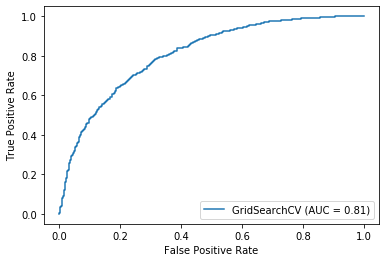

arrhythmia                          1.966827
atherosclero                        0.985669
ethnicity_unknown                   0.817840
age                                 0.683536
renal_failure                       0.502004
mean 51006                          0.439162
diabetes                            0.357366
ethnicity_other                     0.334356
ethnicity_hispanic/latino           0.303915
mean 51277                          0.273612
hypertension                        0.243171
ethnicity_asian                     0.238633
mean 51274                          0.197923
mean 51250                          0.191176
ethnicity_black/african american    0.162752
mean 50902                          0.156409
mean 51249                          0.151475
mean 50885                          0.122447
mean 50882                          0.119899
mean 51265                          0.116469
mean 51222                          0.112706
mean 50861                          0.093429
mean 51248

In [297]:
results(grid_log)

### With Only Mean/Min/Max (Standardized)

Cross Validation
--------------------
Best parameter:  {'C': 0.21544346900318834}
Best CV score:  0.8034
Accuracy Score: 73.15%
_______________________________________________
Classification Report:	Precision Score: 75.84%
			Recall Score: 74.97%
			F1 score: 75.41%
			ROC_AUC score: 72.96%
_______________________________________________
Confusion Matrix: 
 [[559 229]
 [240 719]]



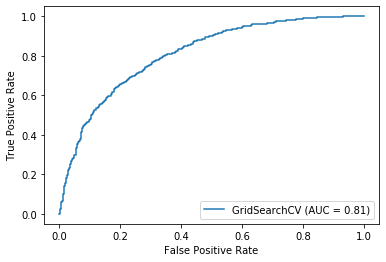

arrhythmia                          1.518817
atherosclero                        0.972996
ethnicity_unknown                   0.711691
age                                 0.672619
diabetes                            0.342747
min 51006                           0.333106
renal_failure                       0.287298
ethnicity_other                     0.276026
ethnicity_hispanic/latino           0.264035
hypertension                        0.257039
mean 51277                          0.235242
mean 51249                          0.193687
min 51237                           0.186048
max 50902                           0.184502
ethnicity_asian                     0.163050
mean 51274                          0.160171
max 50882                           0.149131
ethnicity_black/african american    0.144671
max 51006                           0.132767
max 50970                           0.121203
mean 50970                          0.117032
mean 51250                          0.094567
min 50970 

In [279]:
results(grid_log)

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.010000,0.709057,0.500635,1.000000,0.549513,0.549255
1,0.081818,0.728729,0.549310,0.995829,0.593017,0.574609
2,0.153636,0.753403,0.611174,0.981230,0.647396,0.611436
3,0.225455,0.772594,0.661252,0.958290,0.690326,0.647183
4,0.297273,0.778761,0.691679,0.917623,0.713795,0.676403
5,0.369091,0.776581,0.712043,0.864442,0.726961,0.704932
6,0.440909,0.769154,0.726628,0.806048,0.734402,0.735490
7,0.512727,0.748941,0.727750,0.737226,0.728678,0.761033
8,0.584545,0.721368,0.726605,0.660063,0.720092,0.795226
9,0.656364,0.664581,0.708323,0.553702,0.693188,0.830986


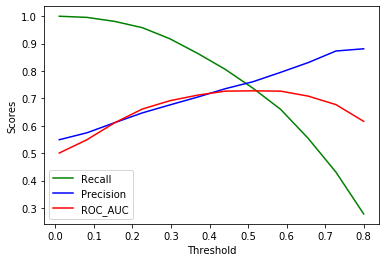

In [280]:
threshold_list = np.linspace(0.01,.8,12)
change_threshold(grid_log, threshold_list, X_test)

### Standardized Model

Cross Validation
--------------------
Best parameter:  {'C': 0.21544346900318834}
Best CV score:  0.8075
Accuracy Score: 73.78%
_______________________________________________
Classification Report:	Precision Score: 76.68%
			Recall Score: 75.08%
			F1 score: 75.87%
			ROC_AUC score: 73.64%
_______________________________________________
Confusion Matrix: 
 [[569 219]
 [239 720]]



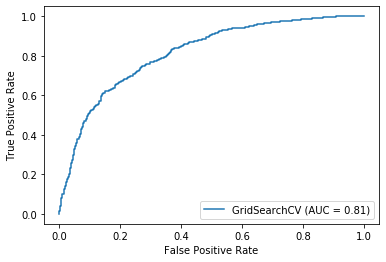

arrhythmia                   1.562585
atherosclero                 0.973695
max 51277                    0.742663
ethnicity_unknown            0.733707
age                          0.601296
above_max 50912              0.583441
above_max 51277              0.487333
max 50912                    0.460121
hypertension                 0.337918
diabetes                     0.326891
ethnicity_other              0.295678
renal_failure                0.232965
ethnicity_hispanic/latino    0.232768
max 50902                    0.221345
max 51006                    0.188401
min 50912                    0.175470
below_min 51249              0.169683
abn_percent 51006            0.162350
mean 51274                   0.151356
max 50970                    0.149702
above_max 50868              0.132527
mean 51249                   0.131939
abn_percent 50912            0.122197
below_min 51279              0.118559
abn_percent 51222            0.115902
dtype: float64


In [140]:
results(grid_log)

### Base Model

Cross Validation
--------------------
Best parameter:  {'C': 0.16681005372000587}
Best CV score:  0.8089
Accuracy Score: 73.50%
_______________________________________________
Classification Report:	Precision Score: 76.33%
			Recall Score: 74.97%
			F1 score: 75.64%
			ROC_AUC score: 73.34%
_______________________________________________
Confusion Matrix: 
 [[565 223]
 [240 719]]



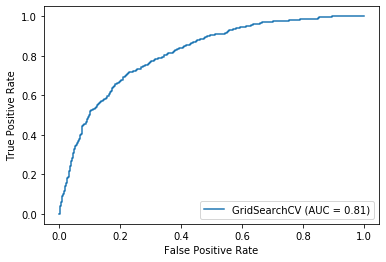

arrhythmia                   1.364216
atherosclero                 0.942269
ethnicity_unknown            0.679730
above_max 50912              0.351829
abn_percent 50885            0.340590
hypertension                 0.317243
diabetes                     0.311300
abn_percent 50912            0.296851
abn_percent 51006            0.282669
max 50912                    0.278597
ethnicity_other              0.252451
ethnicity_hispanic/latino    0.223460
above_max 51221              0.189044
above_max 51277              0.173373
above_max 51249              0.157782
gender                       0.153618
abn_percent 51222            0.153095
abn_percent 50868            0.138406
renal_failure                0.127505
min 50912                    0.120676
max 51277                    0.114238
below_min 51222              0.113904
below_min 50970              0.110992
min 51279                    0.110633
below_min 51006              0.102259
dtype: float64


In [19]:
results(grid_log)

# Random Forest

In [332]:
%%time

from sklearn.ensemble import RandomForestClassifier

param_grid={'n_estimators': np.linspace(400,800,3,dtype=int),
            'max_depth': np.linspace(10,20,3)
            }

rfc = RandomForestClassifier() 

grid_rf = GridSearchCV(estimator = rfc, param_grid = param_grid, cv=3,\
                                       scoring='roc_auc', verbose=1, n_jobs=3)
grid_rf.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  27 out of  27 | elapsed:  1.8min finished


Wall time: 2min 7s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

Cross Validation
--------------------
Best parameter:  {'max_depth': 10.0, 'n_estimators': 800}
Best CV score:  0.8054
Accuracy Score: 73.44%
_______________________________________________
Classification Report:	Precision Score: 72.64%
			Recall Score: 82.79%
			F1 score: 77.39%
			ROC_AUC score: 72.43%
_______________________________________________
Confusion Matrix: 
 [[489 299]
 [165 794]]



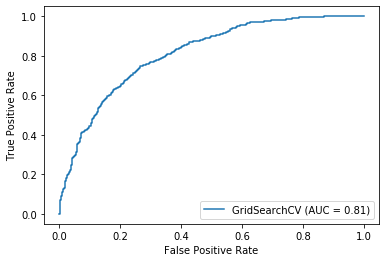

age             0.106358
mean 51006      0.049522
atherosclero    0.047343
min 51006       0.042480
max 51006       0.040183
max 51277       0.029013
mean 51277      0.026489
mean 50912      0.026007
max 50912       0.022519
min 51249       0.019546
min 51277       0.019515
mean 51249      0.019107
min 50912       0.017472
hypertension    0.015729
mean 51274      0.014367
mean 50902      0.014304
max 51249       0.013109
min 51274       0.012935
mean 51237      0.011466
max 50902       0.011415
mean 51265      0.011397
max 51274       0.011363
min 50861       0.011304
mean 51275      0.011302
max 51265       0.011022
dtype: float64


In [333]:
results(grid_rf)

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.010000,0.708795,0.500000,1.000000,0.548941,0.548941
1,0.081818,0.717603,0.521687,0.998957,0.568403,0.559906
2,0.153636,0.737370,0.568233,0.996872,0.610189,0.585067
3,0.225455,0.755573,0.611538,0.989572,0.648540,0.611075
4,0.297273,0.774220,0.658625,0.970803,0.689181,0.643845
5,0.369091,0.778020,0.684611,0.930136,0.708643,0.668666
6,0.440909,0.777473,0.704070,0.885297,0.721809,0.693061
7,0.512727,0.769307,0.724906,0.810219,0.733257,0.732328
8,0.584545,0.749596,0.734705,0.725756,0.733829,0.775056
9,0.656364,0.693829,0.718755,0.603754,0.707499,0.815493


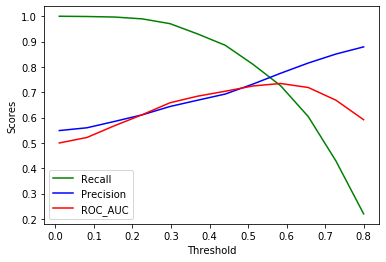

In [334]:
threshold_list = np.linspace(0.01,.8,12)
change_threshold(grid_rf, threshold_list, X_test)